In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_auc_score

### Define all languages in the three datasets

In [2]:
# Define all languages in the three datasets
twitter_languages = [
    "am",  # Amharic
    "ar",  # Arabic
    "bg",  # Bulgarian
    "bn",  # Bengali
    "bo",  # Tibetan
    "bs",  # Bosnian
    "chr", # Cherokee
    "ckb", #
    "cs",  # Czech
    "cy",  # Welsh
    "da",  # Danish
    "de",  # German
    "el",  # Greek
    "en",  # English
    "es",  # Spanish
    "et",  # Estonian
    "fa",  # Persian
    "fil", # Filipino
    "fi",  # Finnish
    "fr",  # French
    "gu",  # Gujarati
    "ha",  # Hausa
    "he",  # Hebrew
    "hi",  # Hindi
    "hu",  # Hungarian
    "hr",  # Croatian
    "ht",  # Haitian
    "hy",  # Armenian
    "id",  # Indonesian
    "in",  #
    "is",  # Icelandic
    "it",  # Italian
    "iu",  # Inuktitat
    "iw",  # 
    "ja",  # Japanese
    "ka",  # Georgian
    "kk",  # Kazakh
    "kn",  # Kannada
    "ko",  # Korean
    "lt",  # Lithuanian
    "lv",  # Latvian
    "ml",  # Malayalam
    "mr",  # Marathi
    "nb",  # Norwegian Bokmål
    "ne",  # Nepali
    "nl",  # Dutch; Flemish
    "no",  # Norwegian
    "pa",  # Panjabi
    "pl",  # Polish
    "ps",  # Pushto
    "pt",  # Portuguese
    "ro",  # Romanian
    "ru",  # Russian
    "sd",  # Sindhi
    "si",  # Sinhala
    "sk",  # Slovak
    "sl",  # Sinhala
    "sn",  # Shona
    "sr",  # Serbian
    "sv",  # Swedish
    "ta",  # Tamil
    "te",  # Telugu
    "th",  # Thai
    "tl",  # Tagalog
    "tr",  # Turkish 
    "ug",  # Uyghur
    "uk",  # Ukrainian
    "und", # Undefined
    "ur",  # Urdu
    "vi",  # Vietnamese
    "yo",  # Yoruba
    "zh",  # Chinese
    "zh-Hant",  # Chinese (Traditional)
]

### Sanity check: Verify missing languages in each dataset

In [9]:
df = pd.read_csv("../data/csv_performance_all_models/xlmt_inference_test_set.csv", 
                 engine='python', on_bad_lines='skip', encoding='utf-8')
df = df.dropna(subset=['tweetid', 'lang'])  # Drop rows where 'tweetid' or 'lang' is null
df[1:3]
df.shape

(2329158, 17)

In [10]:
# Extract unique lang values
unique_langs = df['lang'].dropna().unique()  # Drop NaN values and get unique values
print(len(unique_langs))
unique_langs

189


array(['en', 'es', 'ar', 'pl', 'id', 'ru', 'de', 'et', 'tl', 'und', 'ja',
       'tr', 'ur', 'sk', 'pt', 'ko', 'in', 'ht', 'it', 'vi', 'fr', 'da',
       'iw', 'uk', 'is', 'nl', 'lv', 'sl', 'he', 'fi', 'fa', 'th', 'bg',
       'zh', 'lt', 'cy', 'ro', 'hu', 'no', 'bs', 'ps', 'hr',
       '-66.87918853759766', '35.83332824707031', 'sv',
       '35.66667175292969', '36.83332824707031', 'ka',
       '29.955270767211914', '67.08219909667969', 'sr', 'chr', 'el',
       '31.50200080871582', '-43.20750045776367', '67.07524108886719',
       '36.15721893310547', 'bn', '35.49441909790039', 'hi', 'si', '3.75',
       '-71.64055633544922', '67.06522369384766', '35.945030212402344',
       'te', '31.249670028686523', 'hy', 'kn', '74.802978515625', 'iu',
       '35.20328903198242', '44.40087890625', 'ug', '30.523799896240234',
       '34.33332824707031', '31.38068962097168', 'bo', 'ne',
       '44.48833084106445', '31.178579330444336', 'ckb',
       '37.925758361816406', '36.29127883911133', 'ta',
 

In [11]:
# Filter out invalid entries
filtered_unique_langs = [
    lang for lang in unique_langs 
    if lang.isalpha() and len(lang) <= 4  # Only alphabetic values with up to 4 characters
]

# Find languages in unique_langs but not in twitter_languages
missing_languages = set(filtered_unique_langs) - set(twitter_languages)

# Print missing languages
print("Languages in unique_langs but not in twitter_languages:")
print(missing_languages)

Languages in unique_langs but not in twitter_languages:
set()


### Read filenames

In [12]:
# Step 1: Manually specify the directory and filenames
directory = "../data/csv_performance_all_models/"  # Replace with your directory path
filenames = ["labse_inference_test_set.csv", "small_labse_inference_test_set.csv", 
             "xlmt_inference_test_set.csv"]  # List of filenames

# Combine directory path with filenames
file_paths = [os.path.join(directory, filename) for filename in filenames]

In [ ]:
file_paths

In [ ]:
for filepath in file_paths:
    # Extract the filename and model name
    filename = os.path.basename(filepath)
    model_name = filename.split('_')[0]  # Assumes filename starts with model name (e.g., 'labse_sample.csv')
    print(model_name)

### Combine the three datasets

In [13]:
# Dictionary to store results for each model
model_dfs = {}

# Step 2: Iterate through the file paths
for filepath in file_paths:
    # Extract the filename and model name
    filename = os.path.basename(filepath)
    model_name = filename.split('_')[0]  # Assumes filename starts with model name (e.g., 'labse_sample.csv')
    
    # Read the file
    df = pd.read_csv(filepath, engine='python', on_bad_lines='skip', encoding='utf-8')
    df = df.dropna(subset=['tweetid'])  # Drop rows where 'tweetid' is null
    df = df[df['lang'].isin(twitter_languages)]  # Keep rows with valid 'lang'
    
    # Group by language and calculate global AUC for each language
    auc_data = []
    for lang, group in df.groupby('lang'):
        # Flatten true labels and predictions
        true_labels = group[['post7geo10_true', 'post7geo30_true', 'post7geo50_true', 
                             'pre7geo10_true', 'pre7geo30_true', 'pre7geo50_true']].values.flatten()
        predictions = group[['post7geo10', 'post7geo30', 'post7geo50', 
                             'pre7geo10', 'pre7geo30', 'pre7geo50']].values.flatten()
        
        # Calculate global AUC for the language
        if len(set(true_labels)) > 1:  # Ensure AUC is defined
            auc = roc_auc_score(true_labels, predictions)
        else:
            auc = None  # Skip if only one class is present
        
        # Append results
        auc_data.append({'lang': lang, 'AUC': auc, 'num_obs': len(group)})
    
    # Create a DataFrame for the language-specific AUCs
    model_df = pd.DataFrame(auc_data)
    
    # Store the DataFrame in the dictionary
    model_dfs[f"{model_name}"] = model_df

In [14]:
# Step 3: Combine data from all models for visualization
combined_df = pd.concat(
    [df.assign(model=model_name) for model_name, df in model_dfs.items()]
)

In [15]:
combined_df

,lang,AUC,num_obs,model
0,am,0.750000,3,labse
1,ar,0.696039,354480,labse
2,bg,0.631853,1436,labse
3,bn,0.774123,25,labse
4,bo,0.400000,2,labse
...,...,...,...,...
60,uk,0.785147,6219,xlmt
61,und,0.620159,80697,xlmt
62,ur,0.693811,9189,xlmt
63,vi,0.731447,8859,xlmt


In [16]:
# Sum all values in the num_obs column
total_num_obs = combined_df['num_obs'].sum()
print(f"Total num_obs: {total_num_obs}")

Total num_obs: 6984510


### Filter rows before plotting

In [20]:
# Filter for rows where num_obs >= 10
filtered_df = combined_df[combined_df['num_obs'] >= 120]

# Filter languages that have AUC scores for all three models
langs_with_all_models = (
    filtered_df.groupby('lang')['model']
    .nunique()  # Count the number of unique models per language
    .loc[lambda x: x == 3]  # Keep only languages with all three models
    .index  # Extract the language names
)

# Filter the DataFrame to include only these languages
filtered_df = filtered_df[filtered_df['lang'].isin(langs_with_all_models)]
filtered_df

,lang,AUC,num_obs,model
1,ar,0.696039,354480,labse
2,bg,0.631853,1436,labse
5,bs,0.759916,389,labse
8,cy,0.784787,1269,labse
9,da,0.737405,1997,labse
...,...,...,...,...
60,uk,0.785147,6219,xlmt
61,und,0.620159,80697,xlmt
62,ur,0.693811,9189,xlmt
63,vi,0.731447,8859,xlmt


In [21]:
# Get unique languages from the 'lang' column
unique_languages = filtered_df['lang'].unique()

# Print the number of unique languages and the languages themselves
print(f"Number of unique languages: {len(unique_languages)}")
print("Unique languages:")
print(unique_languages)

Number of unique languages: 44
Unique languages:
['ar' 'bg' 'bs' 'cy' 'da' 'de' 'el' 'en' 'es' 'et' 'fa' 'fi' 'fr' 'he'
 'hr' 'ht' 'hu' 'id' 'in' 'is' 'it' 'iw' 'ja' 'ko' 'lt' 'lv' 'nl' 'no'
 'pl' 'ps' 'pt' 'ro' 'ru' 'sk' 'sl' 'sv' 'th' 'tl' 'tr' 'uk' 'und' 'ur'
 'vi' 'zh']


### Plot AUCs for each language

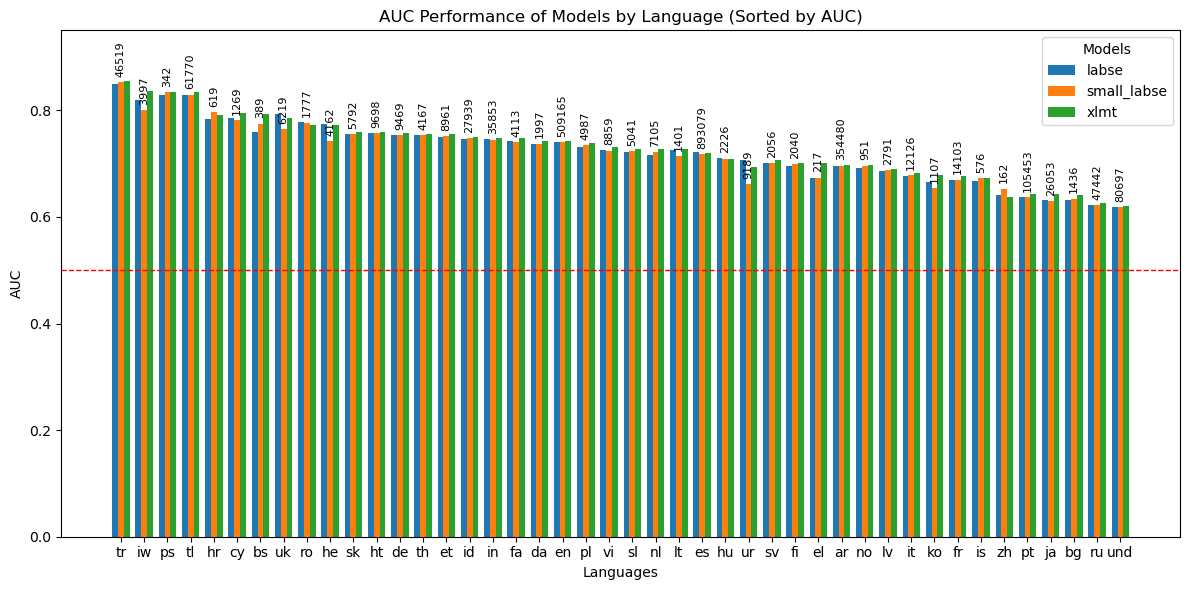

In [24]:
# Step 4: Plot AUCs for each language
# Pivot the data for easier plotting
pivot_df = filtered_df.pivot(index="lang", columns="model", values="AUC").fillna(0)  # Fill NaNs with 0 for plotting
num_obs = filtered_df.groupby("lang")["num_obs"].max()  # Get the number of observations per language

# Sort languages by maximum AUC across all models in descending order
pivot_df['max_auc'] = pivot_df.max(axis=1)  # Calculate the maximum AUC for sorting
pivot_df = pivot_df.sort_values(by='max_auc', ascending=False).drop(columns='max_auc')  # Sort and remove helper column
num_obs = num_obs.loc[pivot_df.index]  # Reorder num_obs to match sorted languages

# Map legend names (replace "small" with "small_labse")
legend_labels = {"labse": "labse", "xlmt": "xlmt", "small": "small_labse"}

# Plotting using subplots
fig, ax = plt.subplots(figsize=(12, 6))  # Explicitly create a figure and axes
bar_width = 0.25
languages = pivot_df.index
index = np.arange(len(languages))  # Numeric positions for the bars

# Bar plot for each model
for i, model in enumerate(pivot_df.columns):
    ax.bar(
        index + i * bar_width,  # Offset each model
        pivot_df[model],  # AUC values for this model
        bar_width,
        label=legend_labels.get(model, model)  # Map to legend label if available
    )

    # Add number of observations only on the middle bar
    if i == 1:  # Assuming the middle bar corresponds to i=1
        for x, y, obs in zip(index + i * bar_width, pivot_df[model], num_obs):
            ax.text(x, y + 0.01, f"{obs}", ha="center", va="bottom", fontsize=8, rotation=90)

# Adjust y-axis limits to create space at the top
ax.set_ylim(0, 0.95)  # Extend the y-axis range slightly beyond 1

# Add a red dashed line at y=0.5
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Add labels, title, and legend
ax.set_xlabel("Languages")
ax.set_ylabel("AUC")
ax.set_title("AUC Performance of Models by Language (Sorted by AUC)")
ax.set_xticks(index + bar_width)  # Center the ticks with language labels
ax.set_xticklabels(languages)
ax.legend(title="Models")

# Adjust layout and save the figure
fig.tight_layout()

In [25]:
# Step 5: Save the plot as an EPS file
fig.savefig("../figures/global_auc_per_language.eps", format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [26]:
fig.savefig("../figures/global_auc_per_language.jpg", format='jpg', dpi=300)